# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

### Par Youcef Benslimane, 28715654

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

    
def imagePad(I,h):
    image = I.copy()
    image = np.pad(image,int(h.shape[0]/2),'constant')
    return image    

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I,s):
    sobelX = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    horizontal = convolve2d(I,sobelX)
    vertical = convolve2d(I,sobelY)
    
    #Compute the gradient
    gradient = np.sqrt(horizontal**2 + vertical**2)
    
    #compute the norm threshold with value s 
    normT = np.where(gradient>s,1,0)
    return normT

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I,s):
    
    res = np.zeros(I.shape)
    
    # The Laplacian filter consists in a convolution with L:
    L = np.array([[0,1,0],[1,-4,1],[0,1,0]]) 
    convolved = convolve2d(I,L)
    
    #Zero padding is required for outside neighbours
    padded = imagePad(convolved,L) 
    
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            
            #for each pixel, compute a 3*3 neighborrow that represents a 3x3 matrix where 
            #The Pixel(i,j) is the center
            neighborrow = padded[x:x+L.shape[0],y:y+L.shape[0]]
            
            # find maximum and minimum of the neighborrow
            maxN = np.amax(neighborrow) 
            minN = np.amin(neighborrow)
            
            # highlight all the zero-crossings
            if (maxN>0 and minN<0 and maxN-minN > s):
                res[x,y] = 1
    return res

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

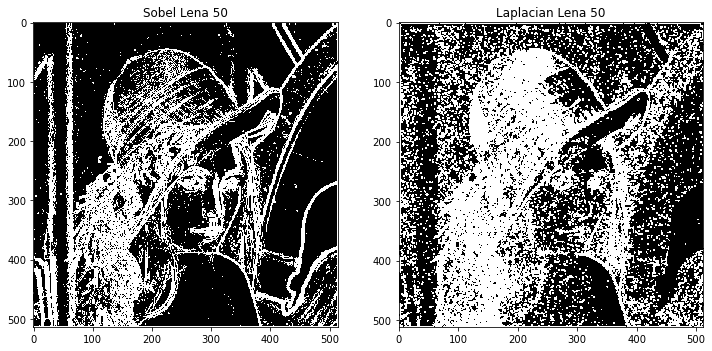

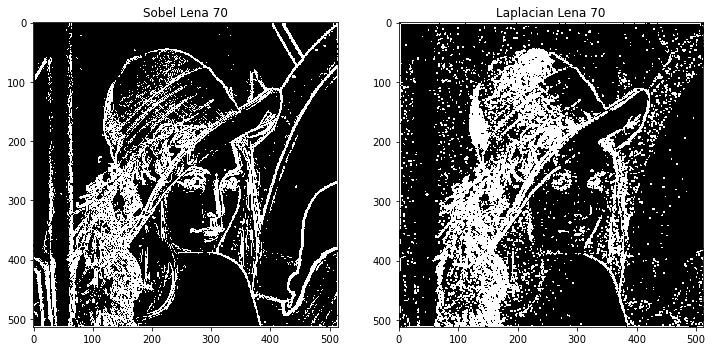

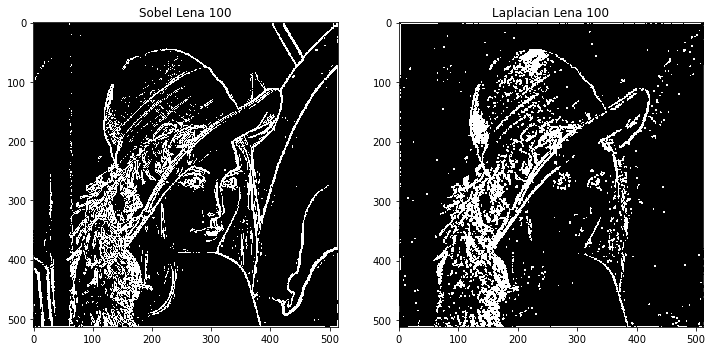

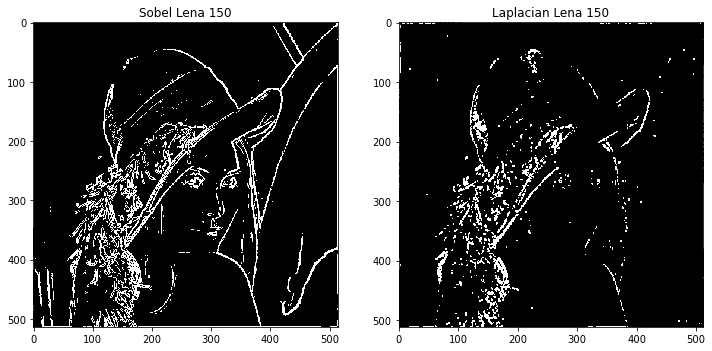

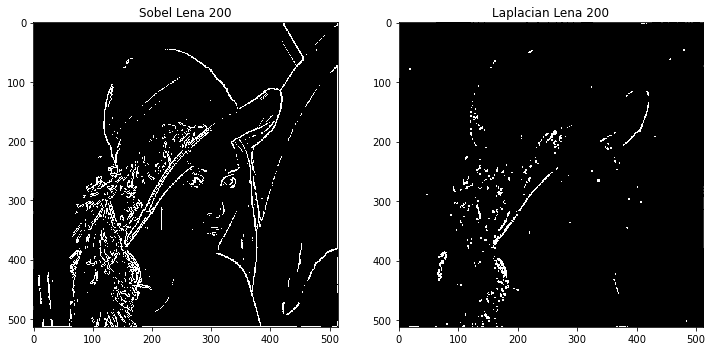

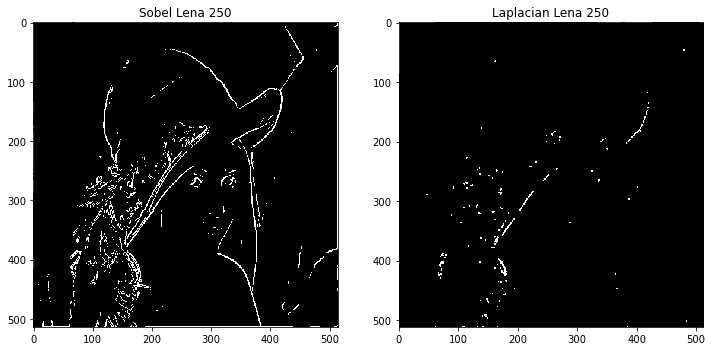

In [4]:
lena = np.array(Image.open('img/lena.png'))

sValues = [50,70,100,150,200,250]

i=0
while i<len(sValues):
    sobelLena = SobelDetector(lena,sValues[i])
    laplacianLena = LaplacianDetector(lena,sValues[i])
    niceDisplay14([sobelLena,laplacianLena],
              ["Sobel Lena " + str(sValues[i]),"Laplacian Lena " + str(sValues[i])])
    i += 1

It seems that s = 70  allows for both detectors to detect approximately the same edges.

We notice that Laplacian detector is highly sensitive to noise. It detects random dots and marks them as edges, as long as they differ from their immediate neighbours, while it misses some of the actual closed outlines of the objets, such as Lena's nose, or Lena's reflection on the mirror. 

We also notice that increasing the threshold decreases the sensitivity for both detectors.

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


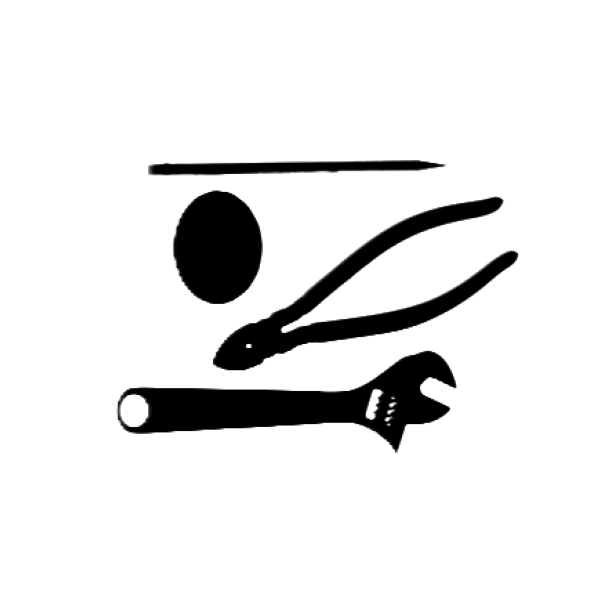

[[4. 3. 3. ... 3. 3. 2.]
 [4. 4. 3. ... 3. 2. 1.]
 [1. 1. 0. ... 0. 4. 4.]
 ...
 [1. 1. 0. ... 0. 4. 4.]
 [1. 2. 3. ... 3. 4. 4.]
 [2. 3. 3. ... 3. 3. 4.]]


<IPython.core.display.Javascript object>


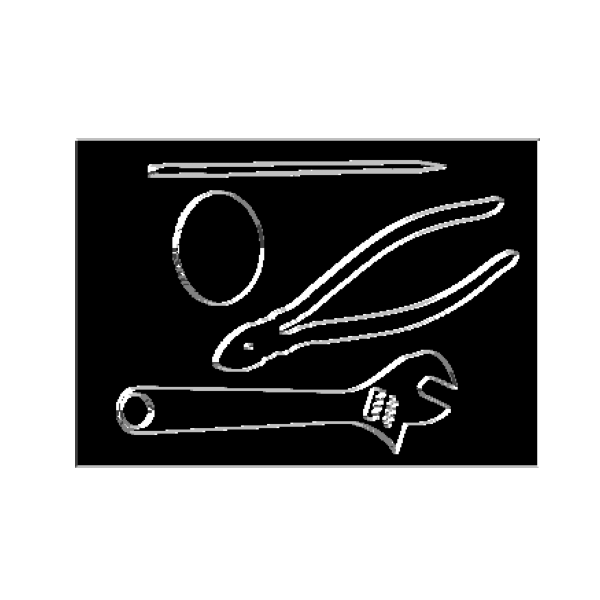

In [5]:
%matplotlib notebook
#### your answer below

# The following function retrieves the spatial derivatives 
#Ix and Iy and The gradient norm from an Image I

def SobelPartOne(I):
    sobelX = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    horizontal = convolve2d(I,sobelX)
    vertical = convolve2d(I,sobelY)
    
    #Compute the gradient
    gradient = np.sqrt(horizontal**2 + vertical**2)
    
    return horizontal, vertical, gradient


tools = np.array(Image.open("img/tools.png"))
imshow(tools)

toolsX, toolsY, toolsGrad = SobelPartOne(tools)
tools_Orientation = orientation(toolsX, toolsY, toolsGrad)
print(tools_Orientation)
imshow(tools_Orientation)

Explain the different values given to a pixel by `orientation()`:

For every pixel, we have the direction of the corresponding gradient value.
Value 1 means that the computed gradient is horizontal.
Value 2 means that the computed gradient is an ascending diagonal.
Value 3 means that the computed gradient is vertical
Value 4 means that the computed gradient is a descending diagonal.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [6]:
def nms(Ig, Ior):

    res = np.zeros(Ig.shape)
    
    #Zero padding is required for outside neighbours
    padded = imagePad(Ig,np.zeros((3,3)))
    
    # The position of the pixels used for the comparison will vary depending on the gradient orientation.
    
    for i in range(Ig.shape[0]):
        for j in range(Ig.shape[1]):
            A = float('inf') 
            B = float('inf')
            #4 cases for each orientation value.
            #and since we padded everything first we start from 1 and not 0 for our indexes
            if Ior[i,j]==1:
                A = padded[i+1,j]
                B = padded[i+1,j+2]
            if Ior[i,j]==2:
                A = padded[i,j+2]
                B = padded[i+2,j]
            if Ior[i,j]==3:
                A = padded[i,j+1]
                B = padded[i+2,j+1]
            if Ior[i,j]==4:
                A = padded[i,j]
                B = padded[i+2,j+2]
  
            if max(Ig[i,j],A,B)==Ig[i,j]:
                res[i,j] = Ig[i,j]
    return res

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


<IPython.core.display.Javascript object>


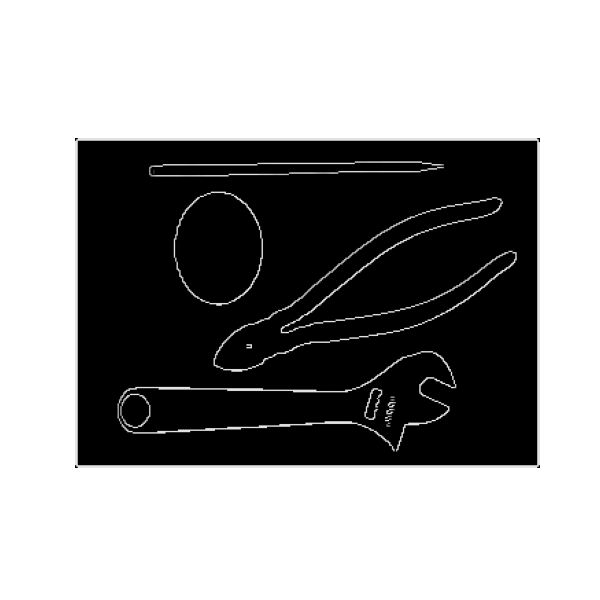

In [7]:
### your answer below
#Tools
tools_Nms = nms(toolsGrad,tools_Orientation)
imshow(tools_Nms)

<IPython.core.display.Javascript object>


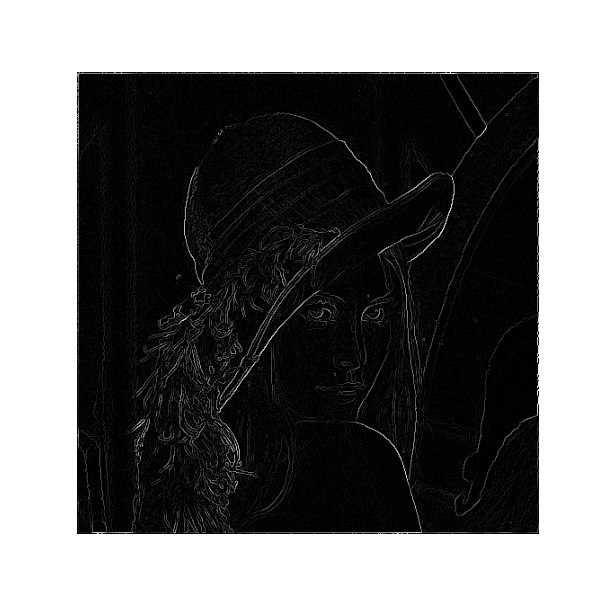

In [42]:
#Lena
lenaX, lenY, lenaGrad = SobelPartOne(lena)
lena_Orientation = orientation(lenaX, lenY, lenaGrad)
lena_Nms = nms(lenaGrad, lena_Orientation)
imshow(lena_Nms)

In [8]:
def GaussianDetector(I,sigma):  
    gaussianFilter = gaussianKernel(sigma)
    convolved = convolve2d(I,gaussianFilter)
    Ix, Iy, Igrad = SobelPartOne(convolved) 
    I_Orientation = orientation(Ix, Iy, Igrad) 
    return Igrad, I_Orientation

<IPython.core.display.Javascript object>


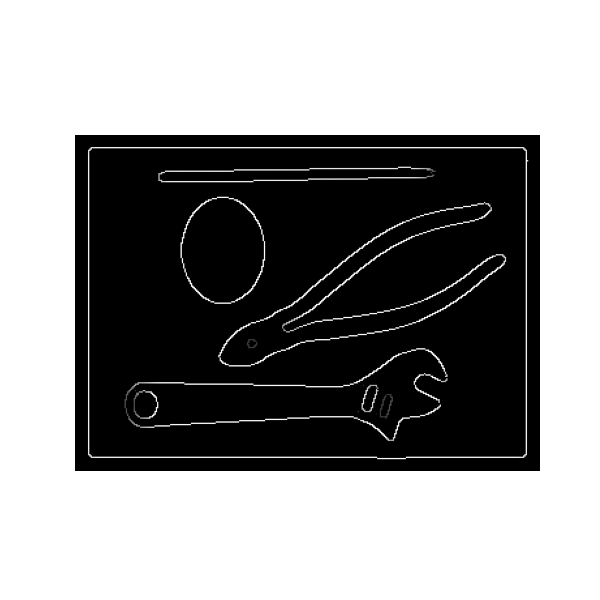

In [44]:
#Tools Gauss
toolsGradG,tools_OrientationG = GaussianDetector(tools,3) 
tools_NmsG = nms(toolsGradG,tools_OrientationG)
imshow(tools_NmsG)

<IPython.core.display.Javascript object>


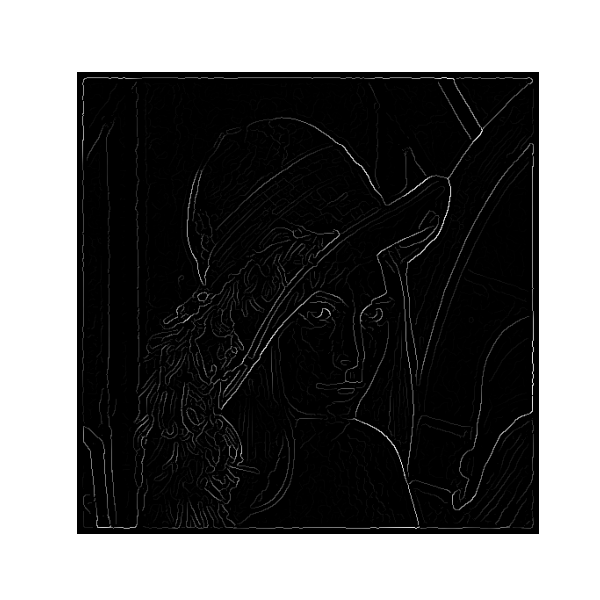

In [9]:
# Lena Gauss
lenaGradG, lena_OrientationG = GaussianDetector(lena,2) 
lena_NmsG = nms(lenaGradG,lena_OrientationG)
imshow(lena_NmsG)


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

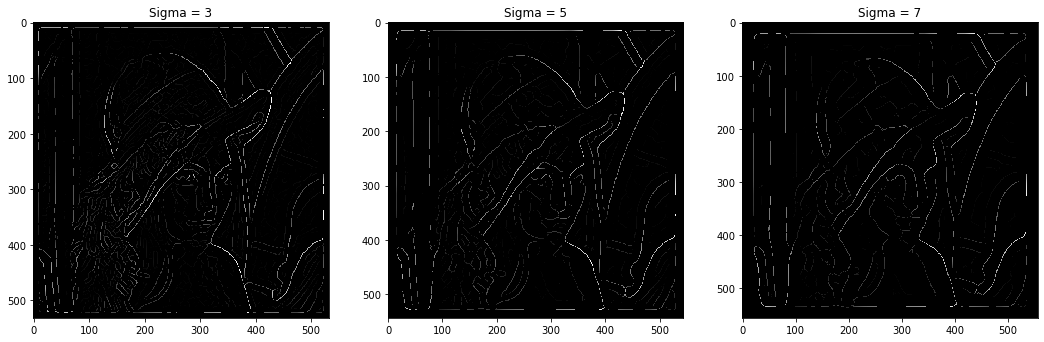

In [32]:
%matplotlib inline
lenaGradG, lena_OrientationG = GaussianDetector(lena,3) 
lena_NmsG3 = nms(lenaGradG,lena_OrientationG)

lenaGradG, lena_OrientationG = GaussianDetector(lena,5) 
lena_NmsG5 = nms(lenaGradG,lena_OrientationG)

lenaGradG, lena_OrientationG = GaussianDetector(lena,7) 
lena_NmsG7 = nms(lenaGradG,lena_OrientationG)

niceDisplay14([lena_NmsG3,lena_NmsG5,lena_NmsG7], ["Sigma = 3","Sigma = 5","Sigma = 7"])


Smoothing helps the program sharpen its wits and separate the noise from the actual edges by discarding the highest frequencies that usually build up a texture's detail that we do not want it to be visible.

Using a Gaussian filter does not change much on tools.gif since it doesn't have much noise. But since Lena is a very noisy image, it's more effective on it.

The higher the $\sigma$, the sparser the edges. Of course, they also get slightly thicker because of the subsidiary blur that occurs when applying such a filter.

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

<IPython.core.display.Javascript object>


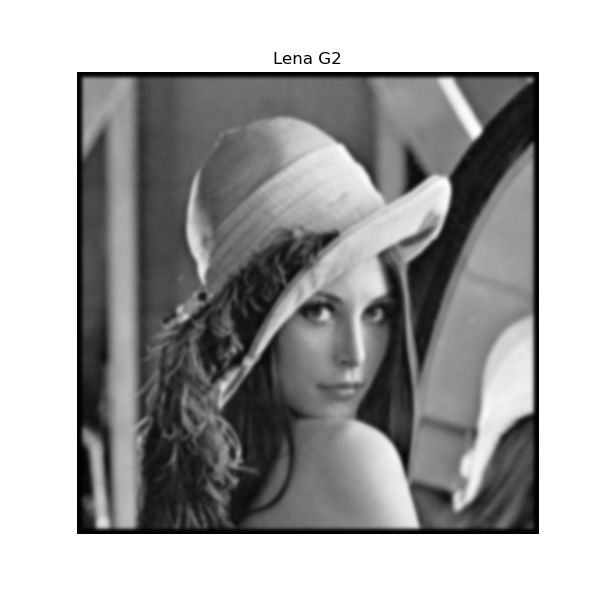

In [48]:
%matplotlib notebook
G2 = gaussianKernel(2)
lena_G2 = convolve2d(lena,G2)
imshow(lena_G2,"Lena G2")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

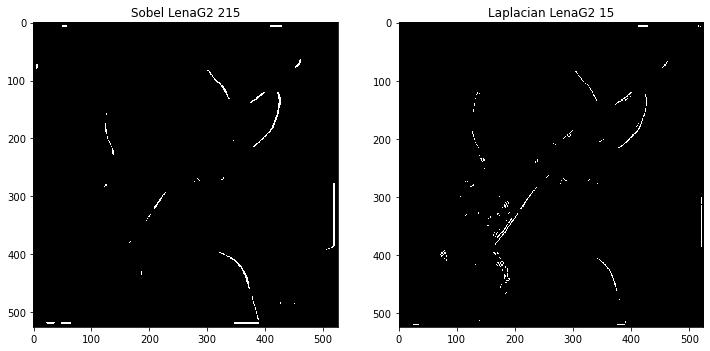

In [51]:
%matplotlib inline

#sobelLena = SobelDetector(lena_G2,200)
#laplacianLena = LaplacianDetector(lena_G2,10)
#niceDisplay14([sobelLena,laplacianLena],
#              ["Sobel LenaG2 200","Laplacian LenaG2 10"])

#sobelLena = SobelDetector(lena_G2,205)
#laplacianLena = LaplacianDetector(lena_G2,15)
#niceDisplay14([sobelLena,laplacianLena],
#              ["Sobel LenaG2 205","Laplacian LenaG2 15"])



sobelLena = SobelDetector(lena_G2,215)
laplacianLena = LaplacianDetector(lena_G2,15)
niceDisplay14([sobelLena,laplacianLena],
              ["Sobel LenaG2 215","Laplacian LenaG2 15"])

The Laplacian detector is more senstitive to noise but with a gaussian filter which is a noise canceller it gave us a more acceptable result. 
The Sobel detector generates thick lines (Fusion of contours) which made the image unreadable.
But in both cases, we cannot see Lena's face.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

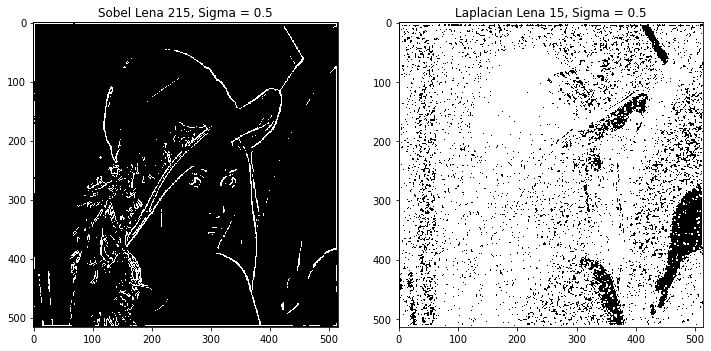

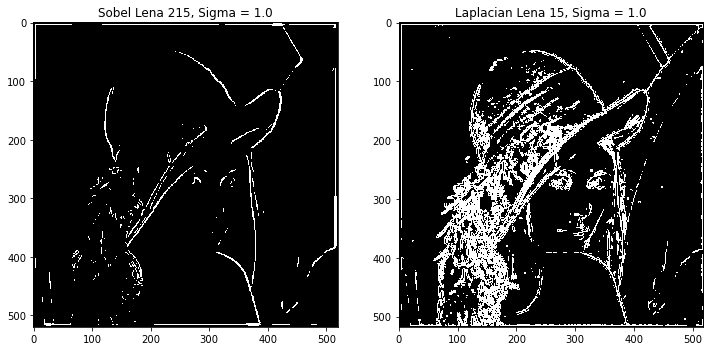

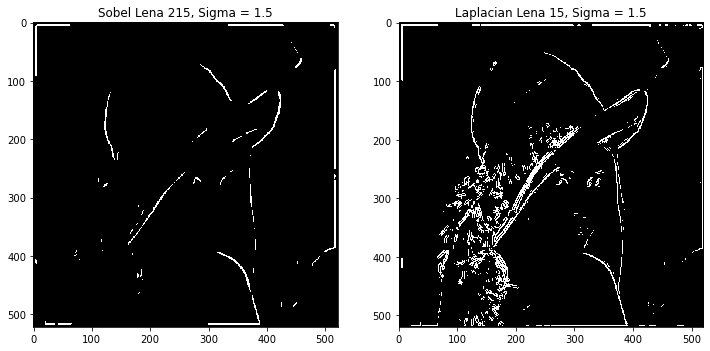

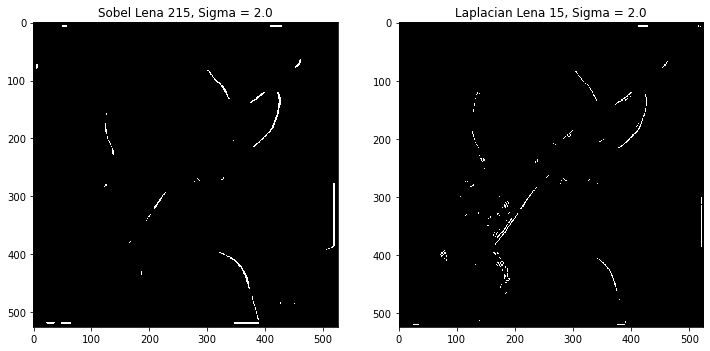

In [53]:
%matplotlib inline

sigma=0.5
while sigma<=2:
    G = gaussianKernel(sigma)
    lenaG = convolve2d(lena,G)

    sobelLena = SobelDetector(lenaG,215)
    laplacianLena = LaplacianDetector(lenaG,15)
    niceDisplay14([sobelLena,laplacianLena],
                  ["Sobel Lena 215, Sigma = " + str(sigma),"Laplacian Lena 15, Sigma = " + str(sigma)])
    sigma+=0.5

Smoothing reduces the noise, but does it help detect a contour with precision?

The Laplacian filter has a "scatter plot" mode of action. It raises a flag where it detects a punctual variation.
A Gaussian filter reduces the difference between a pixel and its neighbours. It is enough to annihilate the lightest noise distributions, but it keeps contrasted lines untouched.
Thus, while noise dwindles, the scattered dots will look like they're drawn exclusively from the most coherent lines. Few of them will be still lost in the background, as they were before the smoothing. 
It makes the result more readable, so it might seem to be more precise, but it's not. This is just about cutting the most irrelevant data. Reducing the noise just cleans up a bit of the chaos, but a Laplacian with a Gaussian still does not perform as well as a Sobel alone.

The Sobel detector for its part loses most of its accuracy after the smoothing. For the record, it relies on gradient computation - treats each pixel as a part of a transitional frontier, searches for such frontiers and reflects them with very thin white lines. Such a detector wouldn't be able to handle a case where these frontiers are too broad and diffuse, and that's why a Gaussian filter gets it into trouble. Gaussian filtering adds a blur, in other words, it increases the gradient's "thickness"; the transition speed between any two regions become too slow, so duplicate detected edge lines accumulate into a pool of white pixels.

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

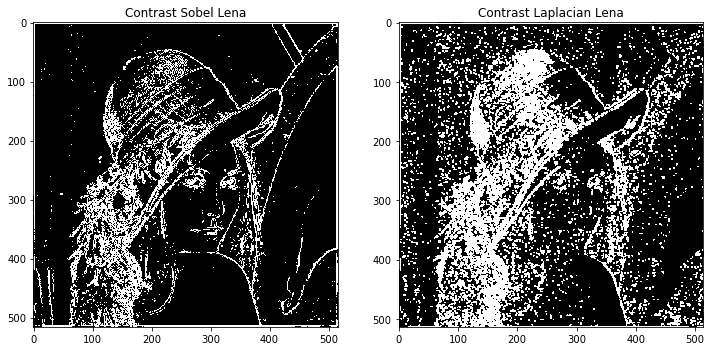

In [59]:
%matplotlib inline
# We use h2 from Exercise 11.3
contrast =[[0,-1,0],[-1,5,-1],[0,-1,0]]
Lena_Contrast = convolve2d(lena,contrast)

sobelLena = SobelDetector(Lena_Contrast,215)
laplacianLena = LaplacianDetector(Lena_Contrast,400)
niceDisplay14([sobelLena,laplacianLena],
              ["Contrast Sobel Lena","Contrast Laplacian Lena"])

Even though the noise is back since it is now highly contrasted, the Sobel filter performs really well. The display is greatly impacted, but the edges still seem to weigh more where they really matter, around the eyes for example.

The Laplacian though does not give us a readable image since, by its nature, it doesn't do well with noise. It doesn't differentiate between pixels that represent noise and pixels that represent edges so it applies to them the exact same treatment.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [10]:
def subSample2(I):
    return I[::2,::2]

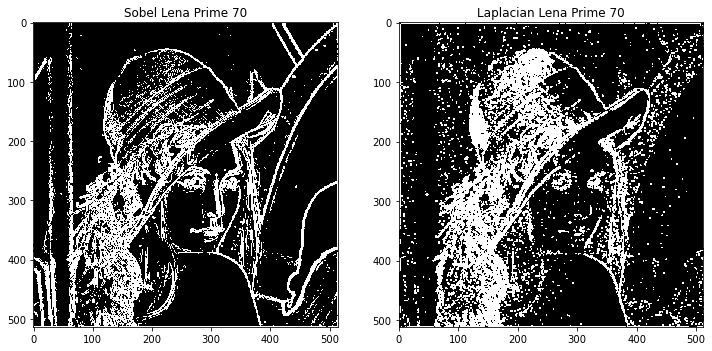

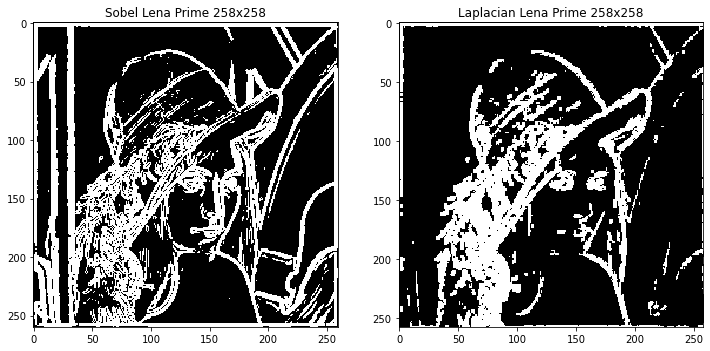

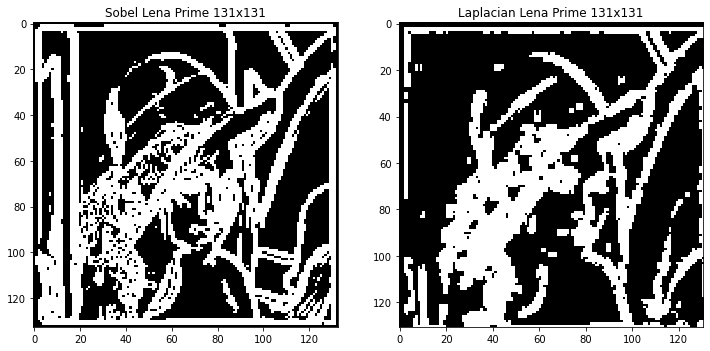

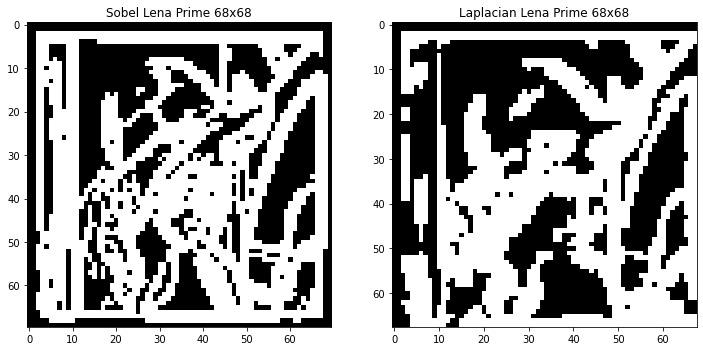

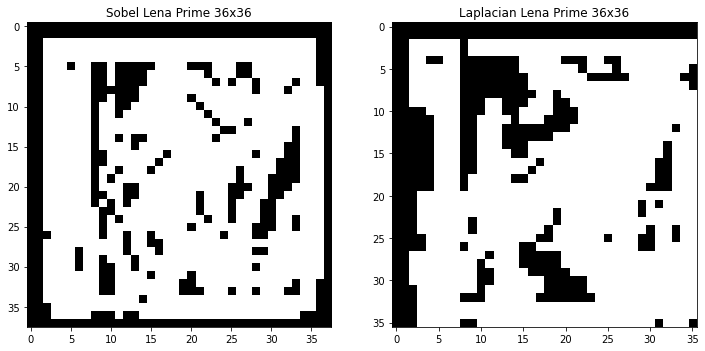

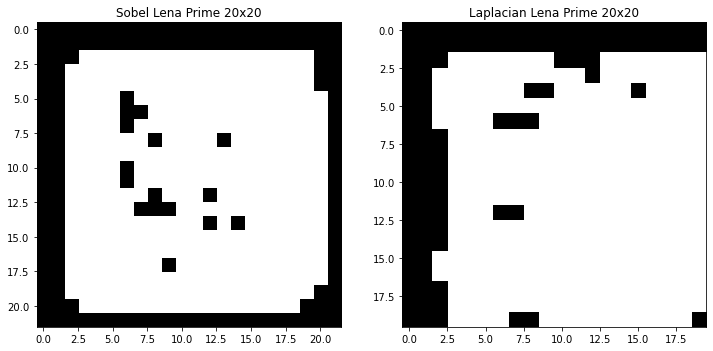

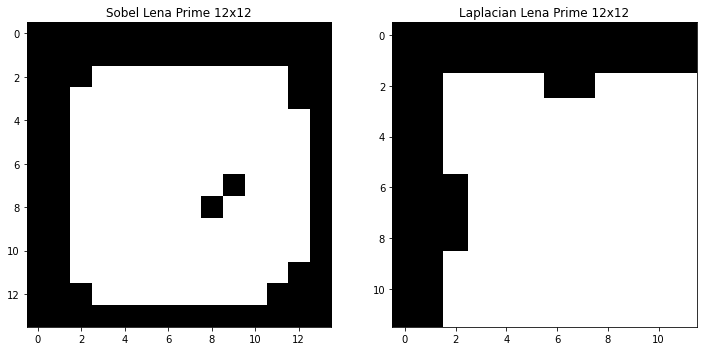

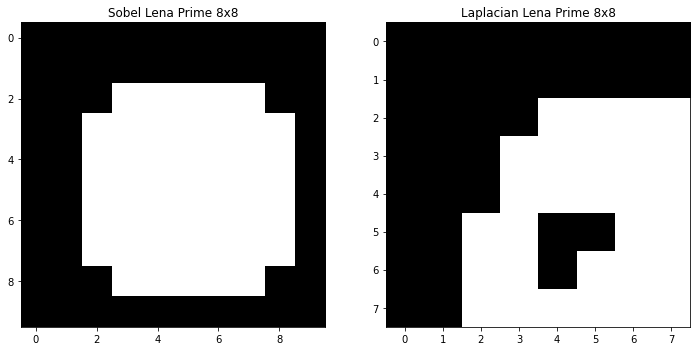

In [61]:
lenaPrime = lena.copy()

sobelLenaPrime = SobelDetector(lenaPrime,70)
laplacianLenaPrime = LaplacianDetector(lenaPrime,70)
niceDisplay14([sobelLenaPrime,laplacianLenaPrime],
          ["Sobel Lena Prime 70","Laplacian Lena Prime 70"])


while (lenaPrime.shape[0]>8):
    G = gaussianKernel(0.8)
    lenaG = convolve2d(lenaPrime,G)
    lenaPrime = subSample2(lenaG)
    
    sobelLena = SobelDetector(lenaPrime,70)
    laplaceLena = LaplacianDetector(lenaPrime,70)
    niceDisplay14([sobelLena,laplaceLena],
              ["Sobel Lena Prime "+ str(lenaPrime.shape[0]) + "x" + str(lenaPrime.shape[0]),"Laplacian Lena Prime "+ str(lenaPrime.shape[0]) + "x" + str(lenaPrime.shape[0])])

Although Lena loses more and more details on each subsampling on both filters, we notice that Laplacian is more tolerant to subsampling than Sobel filter.

Subsampling confuses the orientation matrix of a picture. The farther you sample, the more adjacent pixels will point to contradictory directions. The coherence between the lines and columns is broken as one in every two is purely taken out of the structure at each step; it means that you will soon end up comparing neighbours that were not even close together in the original picture.

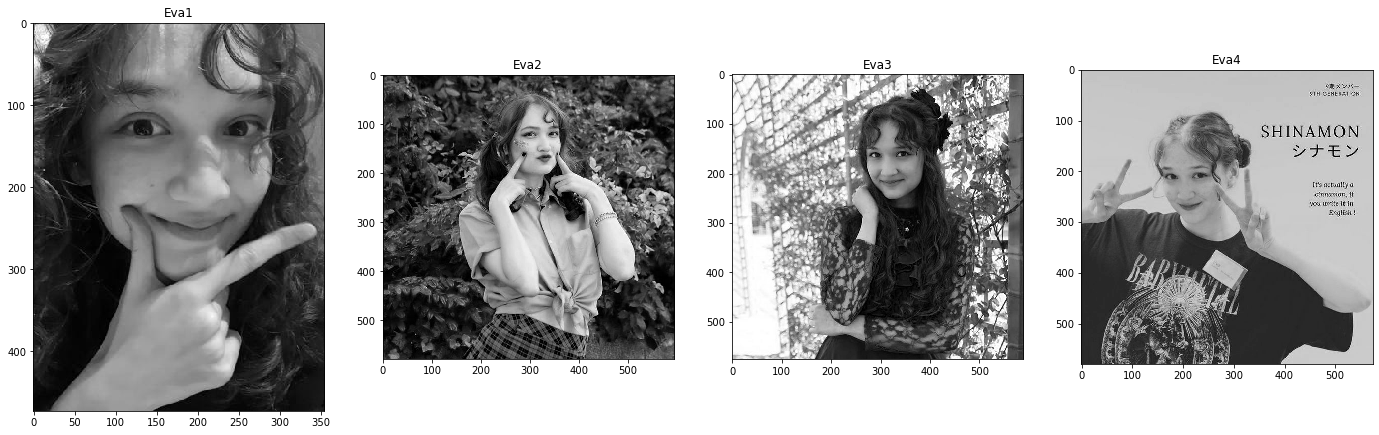

In [13]:
%matplotlib inline

Eva1 = np.array(Image.open("img/1.jpg"))
Eva1 = Eva1[:,:,1]
Eva2 = np.array(Image.open("img/2.jpg"))
Eva2 = Eva2[:,:,1]
Eva3 = np.array(Image.open("img/5.jpg"))
Eva3 = Eva3[:,:,1]
Eva4 = np.array(Image.open("img/7.jpg"))
Eva4 = Eva4[:,:,1]

niceDisplay14([Eva1,Eva2, Eva3, Eva4],
          ["Eva1","Eva2","Eva3","Eva4" ])

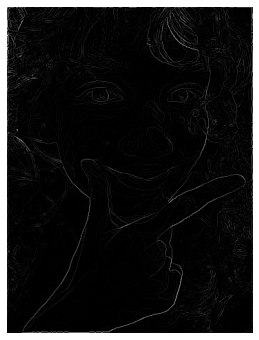

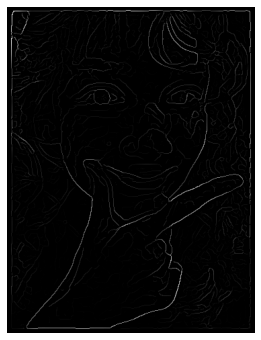

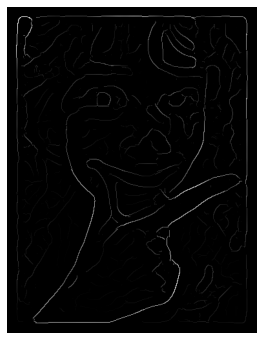

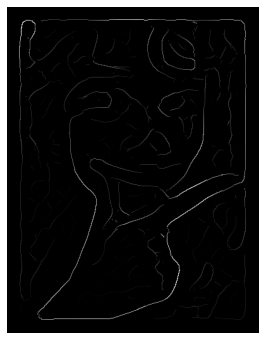

In [17]:
Eva1X, Eva1Y, Eva1Grad = SobelPartOne(Eva1)
Eva1_Orientation = orientation(Eva1X, Eva1Y, Eva1Grad)
Eva1_Nms = nms(Eva1Grad, Eva1_Orientation)
imshow(Eva1_Nms)

Eva1GradG, Eva1_OrientationG = GaussianDetector(Eva1,2) 
Eva1_NmsG = nms(Eva1GradG,Eva1_OrientationG)
imshow(Eva1_NmsG)

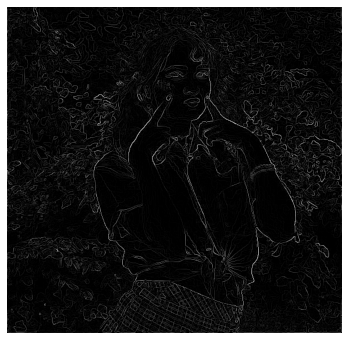

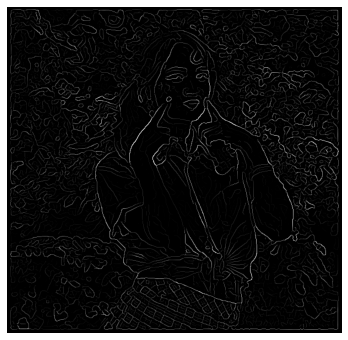

In [22]:
Eva2X, Eva2Y, Eva2Grad = SobelPartOne(Eva2)
Eva2_Orientation = orientation(Eva2X, Eva2Y, Eva2Grad)
Eva2_Nms = nms(Eva2Grad, Eva2_Orientation)
imshow(Eva2_Nms)

Eva2GradG, Eva2_OrientationG = GaussianDetector(Eva2,2) 
Eva2_NmsG = nms(Eva2GradG,Eva2_OrientationG)
imshow(Eva2_NmsG)


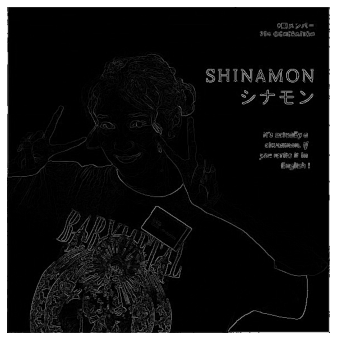

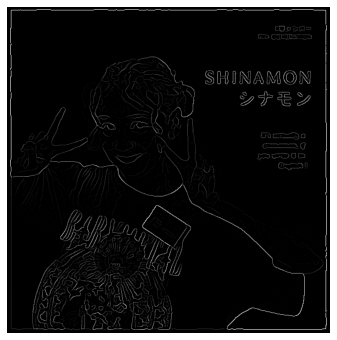

In [26]:
Eva4X, Eva4Y, Eva4Grad = SobelPartOne(Eva4)
Eva4_Orientation = orientation(Eva4X, Eva4Y, Eva4Grad)
Eva4_Nms = nms(Eva4Grad, Eva4_Orientation)
imshow(Eva4_Nms)

Eva4GradG, Eva4_OrientationG = GaussianDetector(Eva4,2) 
Eva4_NmsG = nms(Eva4GradG,Eva4_OrientationG)
imshow(Eva4_NmsG)